# Data Scientist Nanodegree
## Supervised Learning
## Project: Finding Donors for *CharityML*

Welcome to the first project of the Data Scientist Nanodegree! In this notebook, some template code has already been provided for you, and it will be your job to implement the additional functionality necessary to successfully complete this project. Sections that begin with **'Implementation'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a `'TODO'` statement. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.  

>**Note:** Please specify WHICH VERSION OF PYTHON you are using when submitting this notebook. Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

## Getting Started

In this project, you will employ several supervised algorithms of your choice to accurately model individuals' income using data collected from the 1994 U.S. Census. You will then choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. Your goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations.  Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.  While it can be difficult to determine an individual's general income bracket directly from public sources, we can (as we will see) infer this value from other publically available features. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. You can find the article by Ron Kohavi [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). The data we investigate here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.

----
## Exploring the Data
Run the code cell below to load necessary Python libraries and load the census data. Note that the last column from this dataset, `'income'`, will be our target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [1]:
# Import the necessary modules/libraries:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import pandas as pd
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from sklearn.base import clone
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, fbeta_score, make_scorer
from sklearn.model_selection import StratifiedKFold, train_test_split, validation_curve, learning_curve, GridSearchCV
from sklearn.inspection import permutation_importance
from time import time
from IPython.display import display
import visuals as vs

In [2]:
# Read the data:
donors = pd.read_csv("./data/census.csv")

In [3]:
# Success - Display the first record:
display(donors.head(1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K


In [4]:
# Explore the shape:
donors.shape

(45222, 14)

In [5]:
# Dig deeper into the data info:
donors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45222 entries, 0 to 45221
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              45222 non-null  int64  
 1   workclass        45222 non-null  object 
 2   education_level  45222 non-null  object 
 3   education-num    45222 non-null  float64
 4   marital-status   45222 non-null  object 
 5   occupation       45222 non-null  object 
 6   relationship     45222 non-null  object 
 7   race             45222 non-null  object 
 8   sex              45222 non-null  object 
 9   capital-gain     45222 non-null  float64
 10  capital-loss     45222 non-null  float64
 11  hours-per-week   45222 non-null  float64
 12  native-country   45222 non-null  object 
 13  income           45222 non-null  object 
dtypes: float64(4), int64(1), object(9)
memory usage: 4.8+ MB


> - No missing values.
> - Nothing wrong with dtypes.
> - No redundant features or duplicated rows.
> - Categorical columns will require some encoding.

In [6]:
# Explore summary stats:
donors.describe().T

,count,mean,std,min,25%,50%,75%,max
age,45222.0,38.547941,13.217870,17.0,28.0,37.0,47.0,90.0
education-num,45222.0,10.118460,2.552881,1.0,9.0,10.0,13.0,16.0
capital-gain,45222.0,1101.430344,7506.430084,0.0,0.0,0.0,0.0,99999.0
capital-loss,45222.0,88.595418,404.956092,0.0,0.0,0.0,0.0,4356.0
hours-per-week,45222.0,40.938017,12.007508,1.0,40.0,40.0,45.0,99.0


> - Some columns require further preprocessing before applying any ML model:
>> 1. Log transformation.
>> 2. Feature scaling.

### Implementation: Data Exploration
A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000. In the code cell below, you will need to compute the following:
- The total number of records, `'n_records'`
- The number of individuals making more than \$50,000 annually, `'n_greater_50k'`.
- The number of individuals making at most \$50,000 annually, `'n_at_most_50k'`.
- The percentage of individuals making more than \$50,000 annually, `'greater_percent'`.

**HINT:** You may need to look at the table above to understand how the `'income'` entries are formatted. 

In [7]:
# Total number of records:
n_records = donors.shape[0]
n_records

45222

In [8]:
# Number of records where individual's income is more than $50,000:
n_greater_50k = donors.query("income == '>50K'").shape[0]
n_greater_50k

11208

In [9]:
# Number of records where individual's income is at most $50,000:
n_at_most_50k = donors.query("income == '<=50K'").shape[0]
n_at_most_50k

34014

In [10]:
# Percentage of individuals whose income is more than $50,000:
greater_percent = round((donors['income'] == '>50K').mean() * 100, 2)
greater_percent

24.78

In [11]:
# Print the results:
print(f"Total number of records: {n_records}")
print(f"Individuals making more than $50,000: {n_greater_50k}")
print(f"Individuals making at most $50,000: {n_at_most_50k}")
print(f"Percentage of individuals making more than $50,000: {greater_percent}%")

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78%


**Featureset Exploration**

* **age**: continuous. 
* **workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked. 
* **education**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool. 
* **education-num**: continuous. 
* **marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse. 
* **occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces. 
* **relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. 
* **race**: Black, White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other. 
* **sex**: Female, Male. 
* **capital-gain**: continuous. 
* **capital-loss**: continuous. 
* **hours-per-week**: continuous. 
* **native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

----
## Preparing the Data
Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as **preprocessing**. Fortunately, for this dataset, there are no invalid or missing entries we must deal with, however, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: '`capital-gain'` and `'capital-loss'`. 

Run the code cell below to plot a histogram of these two features. Note the range of the values present and how they are distributed.

In [12]:
# Define a function to split the data:
def split_data(data, target_col):
    
    # Create a feature list:
    features = [col for col in data.columns if col != target_col]
    
    # Split data:
    X = data[features].copy()
    y = data[target_col].copy()
    
    # Return the feature matrix & target column:
    return X, y

In [13]:
# Split the data into feature matrix (X) & target column (y):
features_raw, income_raw = split_data(data=donors, target_col='income')

E:\Class Room\My Projects\Udacity-Finding-Donors-for-Charity-ML\visuals.py:48: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


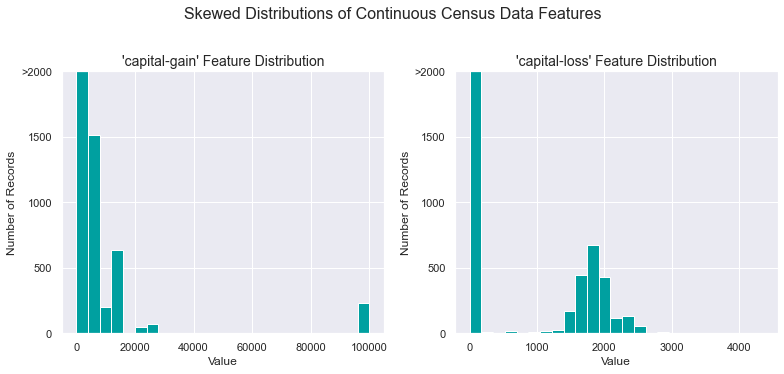

In [14]:
# Plot the skewed continuous features of original data:
vs.distribution(donors)

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the the logarithm successfully.

Run the code cell below to perform a transformation on the data and visualize the results. Again, note the range of values and how they are distributed. 

In [15]:
# Perform log-transformation of the skewed features:
skewed = ['capital-gain', 'capital-loss']
features_log_transformed = pd.DataFrame(data=features_raw)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 1))

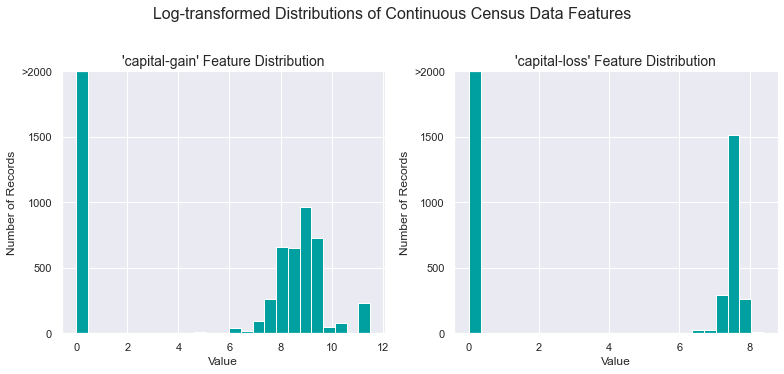

In [16]:
# Plot the new log distributions:
vs.distribution(features_log_transformed, transformed = True)

### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.

Run the code cell below to normalize each numerical feature. We will use [`sklearn.preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) for this.

In [17]:
# Initialize the scaler:
scaler = MinMaxScaler()
numerical_cols = features_log_transformed.select_dtypes(include='number').columns

In [18]:
# Apply the scaler:
features_log_minmax_transformed = pd.DataFrame(data=features_log_transformed)
features_log_minmax_transformed[numerical_cols] = scaler.fit_transform(features_log_transformed[numerical_cols])

In [19]:
# View an example of a record after scaling:
display(features_log_minmax_transformed.head(1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.30137,State-gov,Bachelors,0.8,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.0,0.397959,United-States


In [20]:
# Explore the summary stats again:
features_log_minmax_transformed.describe().T

,count,mean,std,min,25%,50%,75%,max
age,45222.0,0.295177,0.181067,0.0,0.150685,0.273973,0.410959,1.0
education-num,45222.0,0.607897,0.170192,0.0,0.533333,0.600000,0.800000,1.0
capital-gain,45222.0,0.064342,0.214240,0.0,0.000000,0.000000,0.000000,1.0
capital-loss,45222.0,0.042423,0.190454,0.0,0.000000,0.000000,0.000000,1.0
hours-per-week,45222.0,0.407531,0.122526,0.0,0.397959,0.397959,0.448980,1.0


### Implementation: Data Preprocessing

From the table in **Exploring the Data** above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called *categorical variables*) be converted. One popular way to convert categorical variables is by using the **one-hot encoding** scheme. One-hot encoding creates a _"dummy"_ variable for each possible category of each non-numeric feature. For example, assume `someFeature` has three possible entries: `A`, `B`, or `C`. We then encode this feature into `someFeature_A`, `someFeature_B` and `someFeature_C`.

|   | someFeature |                    | someFeature_A | someFeature_B | someFeature_C |
| :-: | :-: |                            | :-: | :-: | :-: |
| 0 |  B  |  | 0 | 1 | 0 |
| 1 |  C  | ----> one-hot encode ----> | 0 | 0 | 1 |
| 2 |  A  |  | 1 | 0 | 0 |

Additionally, as with the non-numeric features, we need to convert the non-numeric target label, `'income'` to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we can avoid using one-hot encoding and simply encode these two categories as `0` and `1`, respectively. In code cell below, you will need to implement the following:
 - Use [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) to perform one-hot encoding on the `'features_log_minmax_transform'` data.
 - Convert the target label `'income_raw'` to numerical entries.
   - Set records with "<=50K" to `0` and records with ">50K" to `1`.

In [21]:
# One-hot encoding of the 'features_log_minmax_transformed' using pandas.get_dummies()
features_final = pd.get_dummies(data=features_log_minmax_transformed)

In [22]:
# Encode the 'income_raw' data to numerical values (0/1):
income = income_raw.apply(lambda x: 1 if x == '>50K' else 0)

In [23]:
# Print the number of features after one-hot encoding:
encoded = list(features_final.columns)
print("Ther are {} total features after one-hot encoding.".format(len(encoded)))

Ther are 103 total features after one-hot encoding.


In [24]:
# Print the encoded feature names:
print(encoded)

['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'workclass_ Federal-gov', 'workclass_ Local-gov', 'workclass_ Private', 'workclass_ Self-emp-inc', 'workclass_ Self-emp-not-inc', 'workclass_ State-gov', 'workclass_ Without-pay', 'education_level_ 10th', 'education_level_ 11th', 'education_level_ 12th', 'education_level_ 1st-4th', 'education_level_ 5th-6th', 'education_level_ 7th-8th', 'education_level_ 9th', 'education_level_ Assoc-acdm', 'education_level_ Assoc-voc', 'education_level_ Bachelors', 'education_level_ Doctorate', 'education_level_ HS-grad', 'education_level_ Masters', 'education_level_ Preschool', 'education_level_ Prof-school', 'education_level_ Some-college', 'marital-status_ Divorced', 'marital-status_ Married-AF-spouse', 'marital-status_ Married-civ-spouse', 'marital-status_ Married-spouse-absent', 'marital-status_ Never-married', 'marital-status_ Separated', 'marital-status_ Widowed', 'occupation_ Adm-clerical', 'occupation_ Armed-Forces', '

### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

Run the code cell below to perform this split.

In [25]:
# Split the data into training & hold-out sets:
X_train, X_test, y_train, y_test = train_test_split(features_final, income, test_size = 0.2, stratify=income, random_state = 42)

In [26]:
# Print the results of the split:
print(f"Training set has {X_train.shape[0]} samples.")
print(f"Testing set has {X_test.shape[0]} samples.")

Training set has 36177 samples.
Testing set has 9045 samples.


----
## Evaluating Model Performance
In this section, we will investigate four different algorithms, and determine which is best at modeling the data. Three of these algorithms will be supervised learners of your choice, and the fourth algorithm is known as a *naive predictor*.

### Metrics and the Naive Predictor
*CharityML*, equipped with their research, knows individuals that make more than \$50,000 are most likely to donate to their charity. Because of this, *CharityML* is particularly interested in predicting who makes more than \$50,000 accurately. It would seem that using **accuracy** as a metric for evaluating a particular model's performace would be appropriate. Additionally, identifying someone that *does not* make more than \$50,000 as someone who does would be detrimental to *CharityML*, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than \$50,000 is *more important* than the model's ability to **recall** those individuals. We can use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).

Looking at the distribution of classes (those who make at most \$50,000, and those who make more), it's clear that most individuals do not make more than \$50,000. This can greatly affect **accuracy**, since we could simply say *"this person does not make more than \$50,000"* and generally be right, without ever looking at the data! Making such a statement would be called **naive**, since we have not considered any information to substantiate the claim. It is always important to consider the *naive prediction* for your data, to help establish a benchmark for whether a model is performing well. That been said, using that prediction would be pointless: If we predicted all people made less than \$50,000, *CharityML* would identify no one as donors. 


#### Note: Recap of accuracy, precision, recall

**Accuracy** measures how often the classifier makes the correct prediction. It’s the ratio of the number of correct predictions to the total number of predictions (the number of test data points).

**Precision** tells us what proportion of messages we classified as spam, actually were spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all positives(all words classified as spam, irrespective of whether that was the correct classificatio), in other words it is the ratio of

`[True Positives/(True Positives + False Positives)]`

**Recall(sensitivity)** tells us what proportion of messages that actually were spam were classified by us as spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all the words that were actually spam, in other words it is the ratio of

`[True Positives/(True Positives + False Negatives)]`

For classification problems that are skewed in their classification distributions like in our case, for example if we had a 100 text messages and only 2 were spam and the rest 98 weren't, accuracy by itself is not a very good metric. We could classify 90 messages as not spam(including the 2 that were spam but we classify them as not spam, hence they would be false negatives) and 10 as spam(all 10 false positives) and still get a reasonably good accuracy score. For such cases, precision and recall come in very handy. These two metrics can be combined to get the F1 score, which is weighted average(harmonic mean) of the precision and recall scores. This score can range from 0 to 1, with 1 being the best possible F1 score(we take the harmonic mean as we are dealing with ratios).

### Question 1 - Naive Predictor Performace
* If we chose a model that always predicted an individual made more than $50,000, what would  that model's accuracy and F-score be on this dataset? You must use the code cell below and assign your results to `'accuracy'` and `'fscore'` to be used later.

**Please note** that the the purpose of generating a naive predictor is simply to show what a base model without any intelligence would look like. In the real world, ideally your base model would be either the results of a previous model or could be based on a research paper upon which you are looking to improve. When there is no benchmark model set, getting a result better than random choice is a place you could start from.

**HINT:** 

* When we have a model that always predicts '1' (i.e. the individual makes more than 50k) then our model will have no True Negatives(TN) or False Negatives(FN) as we are not making any negative('0' value) predictions. Therefore our Accuracy in this case becomes the same as our Precision(True Positives/(True Positives + False Positives)) as every prediction that we have made with value '1' that should have '0' becomes a False Positive; therefore our denominator in this case is the total number of records we have in total. 
* Our Recall score(True Positives/(True Positives + False Negatives)) in this setting becomes 1 as we have no False Negatives.

In [27]:
# Since the model always predicts that an individual gains >50K:
TN, FN = 0, 0

# The true positives is equivalent to the total individuals gaining >50K:
TP = income.sum()

# The false positives is equivalent to the total individuals gaining <=50K:
FP = len(income) - income.sum()

# Calculate accuracy, precision and recall:
accuracy = (TP + TN) / (TP + TN + FP + FN)
recall = TP / (TP + FN)
precision = TP / (TP + FP)

# Calculate F2-score using the formula above and correct values for precision and recall:
f2_score = ((1 + 2**2) * precision * recall) / (2**2 * precision + recall)

# Print the results:
print(f"Naive Predictor: [Accuracy score: {round(accuracy, 4)}, F2-score: {round(f2_score, 4)}]")

Naive Predictor: [Accuracy score: 0.2478, F2-score: 0.6223]


In [28]:
# Another way to create a baseline classifier is by using a dummy classifier:
dummy_clf = DummyClassifier(strategy='constant', constant=1)
dummy_clf.fit(features_final, income)

DummyClassifier(constant=1, strategy='constant')

In [29]:
# Making some predictions:
y_preds =   dummy_clf.predict(features_final) 

In [30]:
# Evaluating the model performance:
accuracy = accuracy_score(income, y_preds)
f2_score = fbeta_score(income, y_preds, beta=2)

In [31]:
# Print the results:
print(f"Naive Predictor: [Accuracy score: {round(accuracy, 4)}, F2-score: {round(f2_score, 4)}]")

Naive Predictor: [Accuracy score: 0.2478, F2-score: 0.6223]


###  Supervised Learning Models
**The following are some of the supervised learning models that are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that you may choose from:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent Classifier (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

### Question 2 - Model Application
List three of the supervised learning models above that are appropriate for this problem that you will test on the census data. For each model chosen

- Describe one real-world application in industry where the model can be applied. 
- What are the strengths of the model; when does it perform well?
- What are the weaknesses of the model; when does it perform poorly?
- What makes this model a good candidate for the problem, given what you know about the data?

##### 1. Gaussian Naive Bayes (GaussianNB)
> - Real-world applications:
>> * Spam filters.
>> * Sentiment analysis.
>> * Recommendation systems.
> - Advantages:
>> * Easy implementation, fast and simple: Probably one of the simplest and easiest to implement machine learning algorithm.
>> * Noise resilience: If your data has noise, irrelevant features, outliers, its prediction capabilities won't be seriously affected.
>> * No overfitting: Since it's not sensitive to noisy features that are irrelevant these won't be well represented in Naive Bayes Model. This also means that there is no risk of overfitting.
>> * Computationally efficient: Naive Bayes uses very little resources compared to other algorithms.
>> * Suitable for large datasets: Naive Bayes runs much more efficiently than kernel methods, SVMs or Neurol Networks. Its time complexity is O(pn) which means its computational needs will grow linearly with data.
> - Disadvantages:
>> * Real world problems, and limittedaApplication: Real datasets come with features that are not so independent of each other at all. The implications of this can vary from extra work (engineering features, more data processing etc.) to model unsuitability.
>> * Biased nature: Naive Bayes processes all features as independent and this means some features might be processed with a much higher bias than we'd wish.
>> * No regression: Naive Bayes Classifier is strictly a classification algorithm and can't be used to predict continuous numerical value, hence no regression with Naive Bayes Classifier.
> - Resources:
>> * https://statquest.org/video-index
>> * https://www.analyticsvidhya.com/blog/2017/09/naive-bayes-explained
>> * https://holypython.com/nbc/naive-bayes-pros-cons
>> * https://www.upgrad.com/blog/naive-bayes-classifier

##### 2. RandomForestClassifier (Random Forest)
> - Real-world applications:
>> * Fraud detection for bank accounts, credit card.
>> * Detect and predict the drug sensitivity of a medicine.
>> * Identify a patient’s disease by analyzing their medical records.
>> * Predict estimated loss or profit while purchasing a particular stock.
> - Advantages:
>> * Excellent predictive powers: Being consisted of multiple decision trees amplifies random forest's predictive capabilities and makes it useful for application where accuracy really matters.
>> * Balanced bias-variance trade-off: Random Forests generally provide high accuracy and balance the bias-variance trade-off well. Since the model’s principle is to average the results across the multiple decision trees it builds, it averages the variance as well.
>> * Easy data preperation: Overall no requirements for normalization or scaling makes Random Forests much more convenient than some other machine learning algorithms when it comes to "data preperation and pre-processing". Random Forests also work well with both categorical and numerical data
>> * Random Forests are not influenced by outliers to a fair degree.
>> * Random Forests can handle linear and non-linear relationships well.
>> * Random Forests implicitly perform feature selection and generate uncorrelated decision trees. It does this by choosing a random set of features to build each decision tree. This also makes it a great model when you have to work with a high number of features in the data.
>> * Optimization pptions: This can be a blessing and a curse depending on what you want. But random forest offers lots of parameters to tweak and improve your machine learning model.
>> *  Sophisticated output: Random Forest also provides a very nice and sophisticated output with variable importance. This interpretation can help you go beyond an accurate prediction and comment on what's more important in achieving the prediction and why.
> - Disadvantages:
>> * Overfitting risk: Although much lower than decision trees, overfitting is still a risk with random forests and something you should monitor.
>> * Biased towards variables with more levels: If your data has categorical variables with different levels of attributes this can be a big problem because random forest algorithm will favor those with more values which can pose a prediction risk.
>> * Limited with Regression: While random forest is almost unmatched in most classification solutions, it can be limited with regression especially when data has linear nature.
>> * Parameter complexity: Although random forests are known to work well without too much optimization they still have lots of hyper-parameters that can -and in some cases should- be adjusted. On top of decision tree parameters (such as leaf, node, splitting, tree size etc.) random forests also have parameters regarding tree amount in the forest (n_parameters), tree building methods (bootstrap) and out of bag score (oob_score).
>> * Computaional cost: Random Forests can be computationally intensive for large datasets.
> - Resources:
>> * https://statquest.org/video-index
>> * https://holypython.com/rf/random-forest-pros-cons
>> * https://medium.datadriveninvestor.com/random-forest-pros-and-cons-c1c42fb64f04
>> * https://www.kaggle.com/general/208443

##### 2. SVC (Support Vector Classifier)
> - Real-world applications:
>> * Face detection.
>> * Text and hypertext categorization.
>> * Classification of images.
>> * Bioinformatics.
>> * Handwriting recognition – We use SVMs to recognize handwritten characters used widely.
> - Advantages:
>> * Thrives in high dimension: When data has high dimension (think 1000+ to infinity features) a Support Vector Machine with the right settings (right kernel choice etc.) can be the way to go and produce really accurate results.
>> * Kernel flexibility: Support Vector Machines are all about choosing the right kernel with the right parameters and this can provide lots of flexibility and a potent toolset. Linear kernels, non-linear kernels, polynomial kernels, RBF, sigmoid and gaussian kernels all have an edge in solving supervised machine learning problems with SVMs or SVRs.
>> * Fast prediction: Support Vector Machines may be relatively sluggish when it comes to training especially with large datasets, however, when it comes to prediction they are quite fast. SVMs handle dataset as a whole at once and in this sense it's not an incremental approach. This means whole data is taken to RAM of a computer during training. Once it's done prediction becomes a breeze.
>> * Both classification and regression skills: SVMs can be used to both classify data and also predict continuous numerical values. Regression variance of Support Vector Machines are usually called SVR (Support Vector Regression).
> - Disadvantages:
>> * Advanced settings: When it comes to Support Vector Machines, correct parameters can define the line between misery and victory. This makes Support Vector Machines difficult to implement sometimes.
>> * More suitable for relatively-small dataset: Support Vector Machines don't have a scalable nature and they don't work that well with mid-size or large datasets.
>> * Costly computation: SVMs are not the most efficient algorithms and it can be quite costly computationally to train them (when applied with kernels and especially with non-linear kernels).
>> * Low interpretability: Support Vector Machines don't provide very sophisticated and interpretable reports that can be interpreted in an easy fashion.
>> * Overfitting risk: Overfitting is another potential side effect of Support Vector Machines and it can be quite difficult to detect or fix at times.
>> * Feature sclaing is necessary: Scaling is an important fundamental step when working with SVMs otherwise features with higher nominal values will dominate the decision-making process while calculating the distance between the plane and support vectors.
>> * Not suitable for noisy data: SVM does not perform very well when the data set has more noise i.e. target classes are overlapping.
>> * Lack of probability estimates: As the support vector classifier works by putting data points, above and below the classifying hyperplane there is no probabilistic explanation for the classification.
> - Resources:
>> * https://statquest.org/video-index
>> * https://holypython.com/svm/support-vector-machine-pros-cons
>> * https://dhirajkumarblog.medium.com/top-4-advantages-and-disadvantages-of-support-vector-machine-or-svm-a3c06a2b107

### Implementation - Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model you've chosen, it's important that you create a training and predicting pipeline that allows you to quickly and effectively train models using various sizes of training data and perform predictions on the testing data. Your implementation here will be used in the following section.
In the code block below, you will need to implement the following:
 - Import `fbeta_score` and `accuracy_score` from [`sklearn.metrics`](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics).
 - Fit the learner to the sampled training data and record the training time.
 - Perform predictions on the test data `X_test`, and also on the first 300 training points `X_train[:300]`.
   - Record the total prediction time.
 - Calculate the accuracy score for both the training subset and testing set.
 - Calculate the F-score for both the training subset and testing set.
   - Make sure that you set the `beta` parameter!

In [32]:
# Define a training & predicting pipeline function:
def train_predict(estimator, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # Fit the estimator to the training set using slicing with 'sample_size':  
    start = time() # Get start time
    estimator = estimator.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    # Calculate the training time:
    results['train_time'] = end - start
        
    # Get the predictions on X_test, then on the first 300 training samples (X_train):
    start = time() # Get start time
    predictions_test = estimator.predict(X_test)
    predictions_train = estimator.predict(X_train[:300])
    end = time() # Get end time
    
    # Calculate the total prediction time:
    results['pred_time'] = end - start
            
    # Calculate the accuracy on the first 300 training samples:
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
        
    # Calculate the accuracy on the test set:
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # Calculate F2-score on the the first 300 training samples:
    results['f_train'] = fbeta_score(y_train[:300], predictions_train, beta=2)
        
    # Calculate F2-score on the test set:
    results['f_test'] = fbeta_score(y_test, predictions_test, beta=2)
       
    # Print a success message:
    print(f"{estimator.__class__.__name__} trained on {sample_size} samples.")
        
    # Return the results:
    return results

### Implementation: Initial Model Evaluation
In the code cell, you will need to implement the following:
- Import the three supervised learning models you've discussed in the previous section.
- Initialize the three models and store them in `'clf_A'`, `'clf_B'`, and `'clf_C'`.
  - Use a `'random_state'` for each model you use, if provided.
  - **Note:** Use the default settings for each model — you will tune one specific model in a later section.
- Calculate the number of records equal to 1%, 10%, and 100% of the training data.
  - Store those values in `'samples_1'`, `'samples_10'`, and `'samples_100'` respectively.

**Note:** Depending on which algorithms you chose, the following implementation may take some time to run!

In [33]:
# Initialize the models:
clf_A = GaussianNB()
clf_B = RandomForestClassifier(random_state=42)
clf_C = SVC(random_state=42)

In [34]:
# Calculate the number of samples for 1%, 10%, and 100% of the training data:
samples_100 = len(donors)
samples_10 = int(0.1 * samples_100)
samples_1 = int(0.01 * samples_100)

In [35]:
%%time
# Collecting results on the learners:
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = train_predict(clf, samples,
                                             X_train, y_train,
                                             X_test, y_test)

GaussianNB trained on 452 samples.
GaussianNB trained on 4522 samples.
GaussianNB trained on 45222 samples.
RandomForestClassifier trained on 452 samples.
RandomForestClassifier trained on 4522 samples.
RandomForestClassifier trained on 45222 samples.
SVC trained on 452 samples.
SVC trained on 4522 samples.
SVC trained on 45222 samples.
Wall time: 4min 22s


E:\Class Room\My Projects\Udacity-Finding-Donors-for-Charity-ML\visuals.py:121: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  pl.tight_layout()


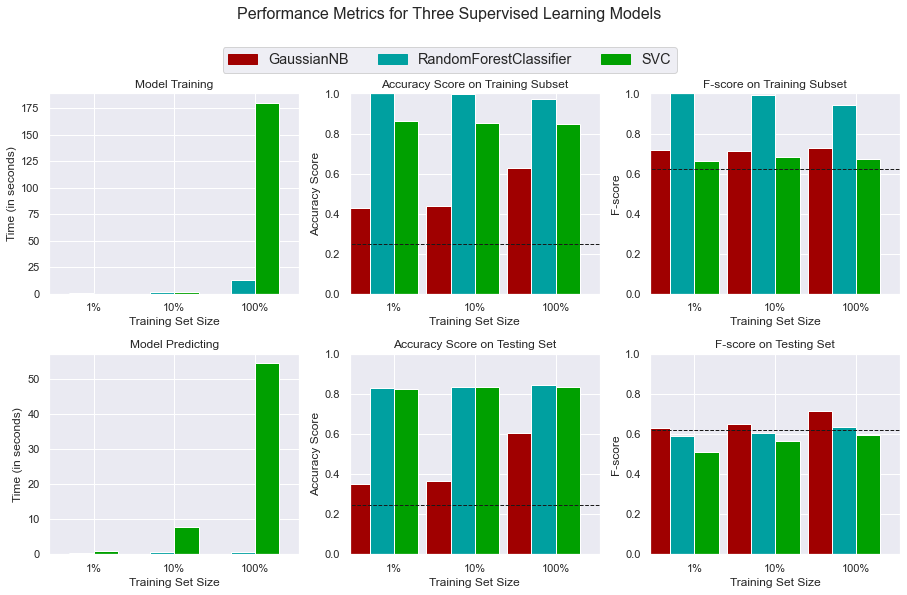

In [36]:
# Plotting the results:
vs.evaluate(results, accuracy, f2_score)

- Fundamentally, the question of “the best model” is about finding a sweet spot in the trade-off between bias and variance. one of the most common diagnostics used to answer such question is the learning curve. The general behavior we would expect from a learning curve is this:
> - A model of a given complexity will overfit a small dataset: this means the training score will be relatively high, while the validation score will be relatively low.
> - A model of a given complexity will underfit a large dataset: this means that the training score will decrease, but the validation score will increase.
> - A model will never, except by chance, give a better score to the validation set than the training set: this means the curves should keep getting closer together but never cross.

In [37]:
# Define a function to plot the learning curve:
def plot_learning_curve(train_sizes, train_scores, test_scores):
        
    # Create means and standard deviations of training set scores:
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)

    # Create means and standard deviations of test set scores:
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    # Draw lines:
    plt.plot(train_sizes, train_mean, '--', color="#111111", label="Training score")
    plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

    # Draw bands:
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

    # Create the plot:
    plt.title("Learning Curve")
    plt.xlabel("Training Set Size"), plt.ylabel("Score"),
    plt.legend(loc="best")
    plt.tight_layout()
    plt.show()

In [38]:
# Define a CV scheme:
kf5 = StratifiedKFold(n_splits=5)

In [39]:
# Define a scoring parameter:
scorer = make_scorer(fbeta_score, beta=2, greater_is_better=True)

In [40]:
# Split the data and perform CV on different sample sizes for clf_A:
train_sizes, train_scores, test_scores = learning_curve(clf_A, X_train, y_train,
                                                        train_sizes=np.linspace(0.01, 1.0, 10),
                                                        cv=kf5, scoring=scorer, random_state=42, n_jobs=-1)

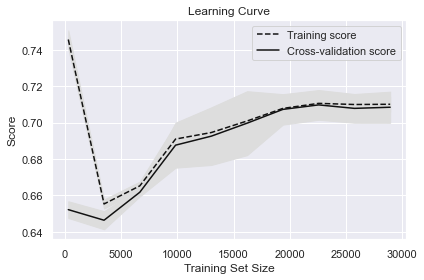

In [41]:
# Plot the learning curve for clf_A:
plot_learning_curve(train_sizes, train_scores, test_scores)

> - No overfitting.
> - No room for improvement by adding more data.

In [42]:
# Split the data and perform CV on different sample sizes for clf_B:
train_sizes, train_scores, test_scores = learning_curve(clf_B, X_train, y_train,
                                                        train_sizes=np.linspace(0.01, 1.0, 10),
                                                        cv=kf5, scoring=scorer, random_state=42, n_jobs=-1)

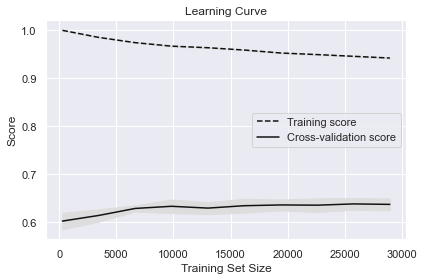

In [43]:
# Plot the learning curve for clf_B:
plot_learning_curve(train_sizes, train_scores, test_scores)

> - The model is clearly overfitting.
> - No room for improvement by adding more data.

----
## Improving Results
In this final section, you will choose from the three supervised learning models the *best* model to use on the student data. You will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F-score. 

### Question 3 - Choosing the Best Model

* Based on the evaluation you performed earlier, in one to two paragraphs, explain to *CharityML* which of the three models you believe to be most appropriate for the task of identifying individuals that make more than \$50,000. 

**Not all errors are created equally!** since I think that CharityML should be a **high-recall model**, I've changed the beta parameter of `fbeta_score` to be **2 instead of 0.5**.


Based on the previous findings, **I would go for Gaussian NB classifier**! That's why:
> - It has the highest `fbeta_score` with beta = 2.
> - It has the lowest training/prediction time.
> - I don't see why it may be not suitable for the data.

### Question 4 - Describing the Model in Layman's Terms

* In one to two paragraphs, explain to *CharityML*, in layman's terms, how the final model chosen is supposed to work. Be sure that you are describing the major qualities of the model, such as how the model is trained and how the model makes a prediction. Avoid using advanced mathematical jargon, such as describing equations.

> Bayes’ theorem is a technique widely used in probability, statistics, and machine learning. It consists of calculating a posterior probability, based on a prior probability and an event. The prior probability is a basic calculation of a probability, given very little information. Bayes’ theorem uses the event to make a much better estimate of the probability in question.
> 
> The naive Bayes algorithm is used when one wants to combine a prior probability together with several events. The word naive comes from the fact that we are making a naive assumption, namely, that the events in question are all independent.
> 
> **Resources**:
>> - [Book] grokking Machine Learning.

### Implementation: Model Tuning
Fine tune the chosen model. Use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. You will need to use the entire training set for this. In the code cell below, you will need to implement the following:
- Import [`sklearn.grid_search.GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Initialize the classifier you've chosen and store it in `clf`.
 - Set a `random_state` if one is available to the same state you set before.
- Create a dictionary of parameters you wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
 - **Note:** Avoid tuning the `max_features` parameter of your learner if that parameter is available!
- Use `make_scorer` to create an `fbeta_score` scoring object (with $\beta = 0.5$).
- Perform grid search on the classifier `clf` using the `'scorer'`, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_fit`.

**Note:** Depending on the algorithm chosen and the parameter list, the following implementation may take some time to run!

- it is occasionally useful to visualize how model performance changes as the hyperparameter value changes.

In [44]:
# Define a function to plot the validation curve:
def plot_validation_curve(train_scores, test_scores):
    
    # Calculate mean and standard deviation for training set scores:
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    
    # Calculate mean and standard deviation for test set scores:
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
    # Plot mean accuracy scores for training and test sets:
    plt.plot(param_range, train_mean, label="Training score", color="black")
    plt.plot(param_range, test_mean, label="Cross-validation score", color="dimgrey")
    
    # Plot accurancy bands for training and test sets:
    plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="gray")
    plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="gainsboro")
    
    # Create plot:
    plt.title("Validation Curve")
    plt.xlabel("Parameter range")
    plt.ylabel("Score")
    plt.tight_layout()
    plt.legend(loc="best")
    plt.show()

In [45]:
# Define a parameter range:
param_name = "var_smoothing"
param_range = np.linspace(0.01, 1, num=10)

In [46]:
# Iterating over the parameter range and perform CV for different values for clf_A:
train_scores, test_scores = validation_curve(clf_A, X_train, y_train,
                                             param_name=param_name, param_range=param_range,
                                             cv=kf5, scoring=scorer, n_jobs=-1)

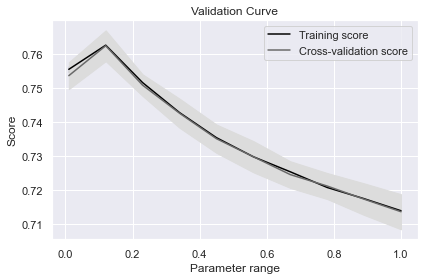

In [47]:
# Plot the learning curve for clf_A:
plot_validation_curve(train_scores, test_scores)

In [48]:
# Create the parameters space:
param_space = {'var_smoothing': np.linspace(0.01,0.21, num=20)}

In [49]:
# Perform the CV grid search:
grid_object = GridSearchCV(estimator=clf_A, param_grid=param_space, scoring=scorer, cv=kf5)

In [50]:
%%time
# Fit the grid search object to the training data to find the optimal parameters:
grid_fit = grid_object.fit(X_train, y_train)

Wall time: 23.5 s


In [51]:
# Get the best estimator:
best_clf = grid_fit.best_estimator_

In [52]:
# Make some predictions using the unoptimized and model:
predictions = (clf_A.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

In [53]:
# Report the before-and-after scores:
print("Unoptimized model\n------")
print(f"Accuracy score on testing data: {round(accuracy_score(y_test, predictions), 4)}")
print(f"F-score on testing data: {round(fbeta_score(y_test, predictions, beta=2), 4)}")
print("\nOptimized Model\n------")
print(f"Final accuracy score on the testing data: {round(accuracy_score(y_test, best_predictions), 4)}")
print(f"Final F-score on the testing data: {round(fbeta_score(y_test, best_predictions, beta=2), 4)}")

Unoptimized model
------
Accuracy score on testing data: 0.6031
F-score on testing data: 0.7172

Optimized Model
------
Final accuracy score on the testing data: 0.7694
Final F-score on the testing data: 0.7626


### Question 5 - Final Model Evaluation

* What is your optimized model's accuracy and F-score on the testing data? 
* Are these scores better or worse than the unoptimized model? 
* How do the results from your optimized model compare to the naive predictor benchmarks you found earlier in **Question 1**?_  

**Note:** Fill in the table below with your results, and then provide discussion in the **Answer** box.

#### Results:

|     Metric     | Unoptimized Model | Optimized Model |
| :------------: | :---------------: | :-------------: | 
| Accuracy Score |      0.6031       |   **0.7694**    |
| F-score        |      0.7172       |   **0.7626**    |

> The simplest way to measure the performance of a classification model is by calculating its accuracy. However, accuracy doesn’t paint the whole picture, because some models exhibit great accuracy but are not good models anyway. To fix this, we’ll use additional metrics, such as f-score.
> 
> - **Accuracy**: The accuracy of a model is the percentage of times that a model is correct. In other words, it is the ratio between the number of correctly predicted data points and the total number of data points.
> 
> Does accuracy paint the whole picture of the model? It doesn’t, as not all errors are equally important! There are 2 types of errors that any model can make:
> - False positive errors.
> - False negative errors.
> 
> In CharityML, false negative errors can cost more than false positive ones (provided that communication costs are irrelevant), that's why we should include another metric to get more information.
> 
> - **Fb-Score**: It's the harmonic mean of recall and precision. If both numbers are high, the F-score is high, however, if one of them is low, the F1-score will be low.
> 
> The Fb-score uses a parameter called b (the Greek letter beta), which can take any positive value. The point of b is to act as a dial that we turn to emphasize precision or recall. In general, the lower the value of b, the more we emphasize precision, and the higher the value of b, the more we emphasize recall.

----
## Feature Importance

An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000.

Choose a scikit-learn classifier (e.g., adaboost, random forests) that has a `feature_importance_` attribute, which is a function that ranks the importance of features according to the chosen classifier.  In the next python cell fit this classifier to training set and use this attribute to determine the top 5 most important features for the census dataset.

### Question 6 - Feature Relevance Observation
When **Exploring the Data**, it was shown there are thirteen available features for each individual on record in the census data. Of these thirteen records, which five features do you believe to be most important for prediction, and in what order would you rank them and why?

> - Capital gain: The more gain, the more the inividual might able to donate.
> - Capital loss: The more loss, the less the inividual might able to donate
> - Occupation: Some occupations may offer more financial stability than others.
> - Marital status: Single people have less financial responsibilities.
> - Age: Older indviduals might be more financially independent.

### Implementation - Extracting Feature Importance
Choose a `scikit-learn` supervised learning algorithm that has a `feature_importance_` attribute availble for it. This attribute is a function that ranks the importance of each feature when making predictions based on the chosen algorithm.

In the code cell below, you will need to implement the following:
 - Import a supervised learning model from sklearn if it is different from the three used earlier.
 - Train the supervised model on the entire training set.
 - Extract the feature importances using `'.feature_importances_'`.

In [54]:
# Fit the model to the training set:
model = RandomForestClassifier(random_state=42).fit(X_train, y_train)

In [55]:
# Extract the feature importances: 
importances = model.feature_importances_

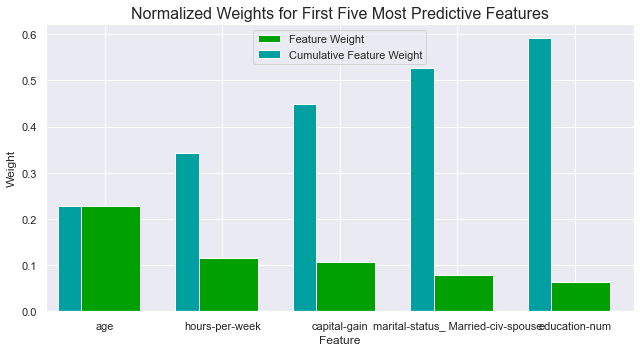

In [56]:
# Plot the feature importances:
vs.feature_plot(importances, X_train, y_train)

### Question 7 - Extracting Feature Importance

Observe the visualization created above which displays the five most relevant features for predicting if an individual makes at most or above \$50,000.  
* How do these five features compare to the five features you discussed in **Question 6**?
* If you were close to the same answer, how does this visualization confirm your thoughts? 
* If you were not close, why do you think these features are more relevant?

> They didin't match completely (3 out of five).

### Feature Selection
How does a model perform if we only use a subset of all the available features in the data? With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute more than half of the importance of **all** features present in the data. This hints that we can attempt to *reduce the feature space* and simplify the information required for the model to learn. The code cell below will use the same optimized model you found earlier, and train it on the same training set *with only the top five important features*. 

In [57]:
# Reduce the feature space:
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

In [58]:
# Fit the "best" model found from grid search earlier:
clf = (clone(best_clf)).fit(X_train_reduced, y_train)


In [59]:
# Make some predictions:
reduced_predictions = clf.predict(X_test_reduced)

In [60]:
# Report scores from the final model using both versions of data:
print("Final Model trained on full data\n------")
print(f"Accuracy on testing data: {round(accuracy_score(y_test, best_predictions), 4)}")
print(f"F-score on testing data: {round(fbeta_score(y_test, best_predictions, beta = 2), 4)}")
print("\nFinal Model trained on reduced data\n------")
print(f"Accuracy on testing data: {round(accuracy_score(y_test, reduced_predictions), 4)}")
print(f"F-score on testing data: {round(fbeta_score(y_test, reduced_predictions, beta = 2), 4)}")

Final Model trained on full data
------
Accuracy on testing data: 0.7694
F-score on testing data: 0.7626

Final Model trained on reduced data
------
Accuracy on testing data: 0.8114
F-score on testing data: 0.4462


### Question 8 - Effects of Feature Selection

* How does the final model's F-score and accuracy score on the reduced data using only five features compare to those same scores when all features are used?
> The model's accuracy has improved, however, its f-score has worsened.
* If training time was a factor, would you consider using the reduced data as your training set?
> No, becuse with Gaussian NB, training time is not a problem.